# Practicals II: interpreting latent spaces learned by DGMs

## Inherently interpretable methods

*Author: Martin*

*Date: August 27, 2022*

This is the Jupyter notenbook for the analysis of the Tasic et al. (2016) dataset using `scVI` from Lopez et al. (2018) and `LDVAE` from Svensson et al. (2020). We have a Julia package for fitting VAEs to single-cell data using count distributions. Based on the Python implementation in the `scvi-tools` package. You can find the documentation for the package at:

[https://maren-ha.github.io/scVI.jl/index.html](https://maren-ha.github.io/scVI.jl/index.html)

In this practical session, we will
* learn how to train a single-cell variational inference (scVI)
* learn how to train a linearly decoded variational autoencoder (LDVAE)
* compute the variance explained by the latent variables
* interpret the results of the LDVAE model

First, we need to install and load `scVI.jl` and some other packages.

In [28]:
using Pkg; # loading the package manager
cd(@__DIR__) # change into the directory where the current file (this notebook) is located
Pkg.activate(".") # activate the environment specified in the .toml files
Pkg.instantiate() # install the necessary dependencies
Pkg.status() # show which packages are currently installed in the environment

# Intall scVI.jl
Pkg.add(url="https://github.com/maren-ha/scVI.jl")

  Activating project at `~/Dropbox/PhD/presentations/GCB2022_workshop/notebook`


Status `~/Dropbox/PhD/presentations/GCB2022_workshop/notebook/Project.toml`
  [fbb218c0] BSON v0.3.5
  [336ed68f] CSV v0.10.4
  [5d742f6a] CSVFiles v1.0.2
  [159f3aea] Cairo v1.0.5
  [a93c6f00] DataFrames v1.3.4
⌃ [31c24e10] Distributions v0.25.68
  [587475ba] Flux v0.13.5
  [92fee26a] GZip v0.5.1
  [c91e804a] Gadfly v1.3.4
  [f67ccb44] HDF5 v0.16.11
  [4345ca2d] Loess v0.5.4
  [d96e819e] Parameters v0.12.3
  [92933f4c] ProgressMeter v1.7.2
  [276daf66] SpecialFunctions v2.1.7
  [2913bbd2] StatsBase v0.33.21
  [24678dba] TSne v1.3.0
  [899adc3e] TensorBoardLogger v0.1.19
  [c4f8c510] UMAP v0.1.9
  [112f6efa] VegaLite v2.6.0
⌃ [fdbf4ff8] XLSX v0.8.2
  [add38077] scVI v0.1.0 `https://github.com/maren-ha/scVI.jl#main`
  [8bb1440f] DelimitedFiles
  [37e2e46d] LinearAlgebra
  [9a3f8284] Random
  [10745b16] Statistics
Info Packages marked with ⌃ have new versions available


    Updating git-repo `https://github.com/maren-ha/scVI.jl`
   Resolving package versions...
  No Changes to `~/Dropbox/PhD/presentations/GCB2022_workshop/notebook/Project.toml`
  No Changes to `~/Dropbox/PhD/presentations/GCB2022_workshop/notebook/Manifest.toml`


## Load the data 

We will use a dataset from Tasic et al. (2016), where gene expression is profiled in 1525 single neurons, extracted from the cortices of mice. The authors reported a set of 104 genes (Figure 3 of Tasic et al.), based on which different subtypes of neurons can be discriminated and a set of 80 neurotransmitter receptor genes (Figure S15 of Tasic et al.), totalling to 184 genes. 

The data from Tasic et al. (2016) has been stored in the [Gene expression Omnibus (GEO)](https://www.ncbi.nlm.nih.gov/geo/) under accession number GSE71585. 

We have downloaded the expression data and the correspoding sample description sheet from the GEO and removed the samples from the expression data which have been flagged by Tasic et al. (2016) as being of bad quality. Since the samples of bad quality are not contained within the sample description sheet, we can filter the samples of bad quality by comparing the sample IDs in the expression data with the IDs in the sample description sheet. 

Further, we have removed genes which are expressed with less than 10 aligned reads in less than 20 samples. This is necessary since many genes are usually expressed only in a single cell and consequently these genes do not substantially represent the structure in the data.

Next, the data has been normalized for sequencing depth using an algorithm from DESeq (Anders and Huber, 2010) and then log-transformed and standardized. Normalization for sequencing depth is important since the number of aligned reads per sample fluctuate which affects the estimated expression level for each gene. The algorithm of Anders and Huber (2010) calculates correction factors, one for each sequencing library, i.e. sample, by which the sequencing data are divided. 

The data contains expression levels of over 15.119 genes in 1679 samples. To lower computational demands of the following analysis while still maintaining most of the biological signal int he dataset, we have subsetted the data using a set of genes identified as most relevant by Tasic et al. (2016): Specifically, we use the marker genes which are known to indicate cell type membership ([Figure 3](https://www.nature.com/articles/nn.4216/figures/3) in Tasic et al. (2016)) and the neurotransmitter receptorgenes which are differentially expressed in different neuron cell types but have a less pronounced expression pattern (supplementary material, [Figure S 15](https://static-content.springer.com/esm/art%3A10.1038%2Fnn.4216/MediaObjects/41593_2016_BFnn4216_MOESM67_ESM.pdf))
 
Finally, we selected only the neural cells using the cell type annotation provided by Tasic et al. (2016), and annotated the cell types as GABAergic vs. Glutamatergic. 

The complete preprocessing can be reproduced by running the script `preprocess_Tasic.jl`, where at the end the following four files are saved to the `data` subfolder: 

 * `Tasic_genenames.txt` - list of selected genes 
 * `Tasic_countmat.txt` - the normalized count matrix, subsetted to the relevant genes and neural cells 
 * `Tasic_celltypes.txt` - the cell type annotation of the cells in `Tasic_countmat.txt`, as provided by Tasic et al. (2016)
 * `Tasic_receptorandmarkers.txt` - the annotation of cells as GABAergic vs. Glutamatergic. 

In [29]:
# Load tasic data using scVI.jl convenience function
using scVI
adata = load_tasic("/Users/martintreppner/Dropbox/PhD/presentations/GCB2022_workshop/code/data/")

# Subset data set according to preprocessing from Tasic et al. (2016)
subset_tasic!(adata)

AnnData object with a countmatrix with 1525 cells and 180 genes
   layers dict with the following keys: ["normalized_counts", "counts"]
   unique celltypes: ["Vip", "L4", "L2/3", "L2", "Pvalb", "Ndnf", "L5a", "L5", "Sst", "L6b", "Sncg", "Igtp", "Smad3", "L5b", "L6a"]


## Single-Cell Variational Inference (scVI)

The scVI model proposed by Lopez et al. (2018) is a framework, based on variational autoencoders, which is adapted to particularities of scRNA-seq data.

The model comprises two components, the encoder and the decoder parts of the network. Lopez et al. (2018) use four neural networks for encoding the size factors and the latent variables. The probabilistic model of scVI is based on a gamma-Poisson mixture. It starts by sampling from the latent space, a standard multivariate normal distribution, which is then fed into a neural network—together with the batch annotation. The neural network then learns the mean proportion of transcripts expressed across all genes. The output is used to sample from a gamma distribution together with the inverse dispersion. The model accounts for technical effects by incorporating a library size scaling factor which, in combination with the gamma-distributed samples, is used to sample from a Poisson distribution. This mixture of the gamma and Poisson distribution is equivalent to the negative binomial distribution. scVI additionally learns a neural network to account for technical dropouts.

<img src="figures/scvi_architecture.png" />

*Taken from: Lopez, R., et al. "Deep generative modeling for single-cell transcriptomics." Nature methods 15.12 (2018)*

### Initialize scVI model

First, we compute the library sizes. The `init_library_size()` function computes the mean and variance of the logarithmized gene expression counts for each batch. Here, we only have data from one batch and therefore we get a scalar for the mean and variance, respectively.

In [30]:
# calculate library size 
library_log_means, library_log_vars = init_library_size(adata)

([11.124279022216797], [0.4693736433982849])

Next, we initialize the single-cell variational autoencoder `scVAE()`. 
* `dispersion`: refers to the dispersion (width) parameter of the negative binomial distribution. It can either be constant per gene across cells or can be estimated for every gene in every cell. 
* `gene_likelihood`: refers to the generative distribution to parameterize in the decoder. It can be either zero inflated negative binomial `:zinb`, negative binomial `:nb`, or Poisson `:poisson`.

In most cases, the negative binomial distribution is a good fit to model scRNA-seq data. However, the model can also estimate the parameters for a zero-inflation term, allowing for acknowledging a higher number of zeros than expected.

In [31]:
# Initiate model and set model hyperparameters
using Random
Random.seed!(111)
m = scVAE(size(adata.countmatrix,2);
        n_layers=1,
        n_latent=4,
        dispersion=:gene,
        gene_likelihood=:nb,
        library_log_means=library_log_means,
        library_log_vars=library_log_vars
);

### Set training hyperparameters

In [32]:
# Set training hyperparameters
training_args = TrainingArgs(
    max_epochs=200,
    batchsize=64,
    lr=0.001,
    n_epochs_kl_warmup=50,
    weight_decay=Float32(1e-6),
    register_losses=true,
    progress=false
);

### Train model

In [33]:
Random.seed!(59)
train_model!(m, adata, training_args)

┌ Info: Starting training for 200 epochs...
└ @ scVI /Users/martintreppner/.julia/packages/scVI/KqfV9/src/Training.jl:73
┌ Info: training complete!
└ @ scVI /Users/martintreppner/.julia/packages/scVI/KqfV9/src/Training.jl:93


(scVAE(180, 1, 128, 4, 1, :gene, 0.1f0, true, :nb, :normal, true, Dict{Any, Any}("total_loss" => Any[1464.9069f0, 1330.2977f0, 1196.6565f0, 1080.1259f0, 975.5964f0, 902.8193f0, 862.7054f0, 830.7064f0, 804.0114f0, 779.7354f0  …  462.43878f0, 462.0931f0, 461.75403f0, 461.67123f0, 460.9368f0, 460.70245f0, 461.78812f0, 461.3695f0, 460.0372f0, 461.13742f0], "kl_z" => Any[11.562287f0, 10.653239f0, 12.110998f0, 12.790958f0, 13.951251f0, 14.671488f0, 14.30169f0, 14.62534f0, 15.049326f0, 15.922423f0  …  7.9435167f0, 7.7994876f0, 7.8199053f0, 7.674694f0, 7.4577765f0, 7.4251523f0, 7.629356f0, 7.509745f0, 7.725549f0, 8.249417f0], "reconstruction" => Any[1464.6755f0, 1329.8716f0, 1195.9302f0, 1079.1029f0, 974.2015f0, 901.0586f0, 860.7034f0, 828.3662f0, 801.30237f0, 776.55096f0  …  454.49524f0, 454.29364f0, 453.93414f0, 453.99655f0, 453.4791f0, 453.27722f0, 454.1588f0, 453.85992f0, 452.31168f0, 452.88806f0], "kl_l" => Any[0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0  …  0.0f0

### Evaluate training and visualize latent representation

In [34]:
# Extract reconstruction loss from trained model
using DataFrames
reconstruction_loss_scvi = m.loss_registry["reconstruction"];
reconstruction_loss_scvi = DataFrame(hcat(collect(1:size(reconstruction_loss_scvi,1)), 
        reconstruction_loss_scvi, repeat(["scVI"], size(reconstruction_loss_scvi,1))), :auto);
rename!(reconstruction_loss_scvi, :x1 => :epoch, :x2 => :reconstruction_loss, :x3 => :model);

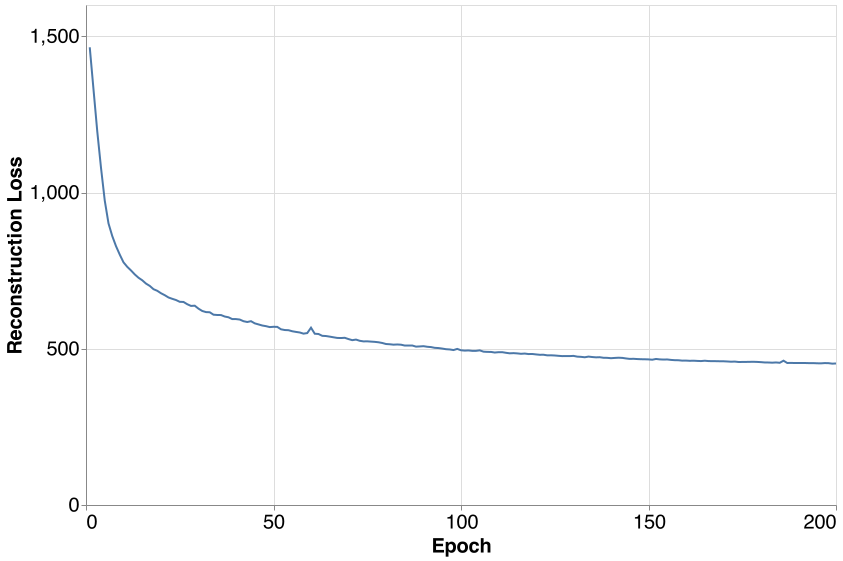

In [35]:
# Plot training progress
using VegaLite
reconstruction_loss_scvi |>
@vlplot(
    width=750,
    height=500,
    :line, 
    x={"epoch:q", title="Epoch", axis={titleFontSize=20, labelFontSize=20, tickCount=5}}, 
    y={"reconstruction_loss:q", title="Reconstruction Loss", 
    axis={titleFontSize=20, labelFontSize=20, tickCount=5}}
)

In [36]:
# Extract latent representation
latent = get_latent_representation(m, adata.countmatrix)

4×1525 Matrix{Float32}:
 -2.4676     -1.12852    0.845094  …  -1.13327   -0.197728  -1.25715
 -0.236943    0.425448  -0.761608      0.836138   1.42523    0.684657
 -0.0702118  -0.485994   1.28084      -0.704473  -0.831366  -0.77548
  1.52614     1.74603    0.702737      2.15302    1.3302     2.16399

In [37]:
# Compute UMAP
using UMAP
umap_latent = umap(latent, 2; min_dist = 0.3); # # umap input assumes shape n_featues x n_samples
umap_latent = Array{Float64,2}(umap_latent');
umap_plot = DataFrame(UMAP1=umap_latent[:,1],UMAP2=umap_latent[:,2]);
umap_plot[!,:CellType] = vec(adata.celltypes);

You can see that using the 4-dimensional representation that `scVI` has learned, we can use UMAP to further reduce the dimensionality and get a good glimpse of our samples the cell type composition.

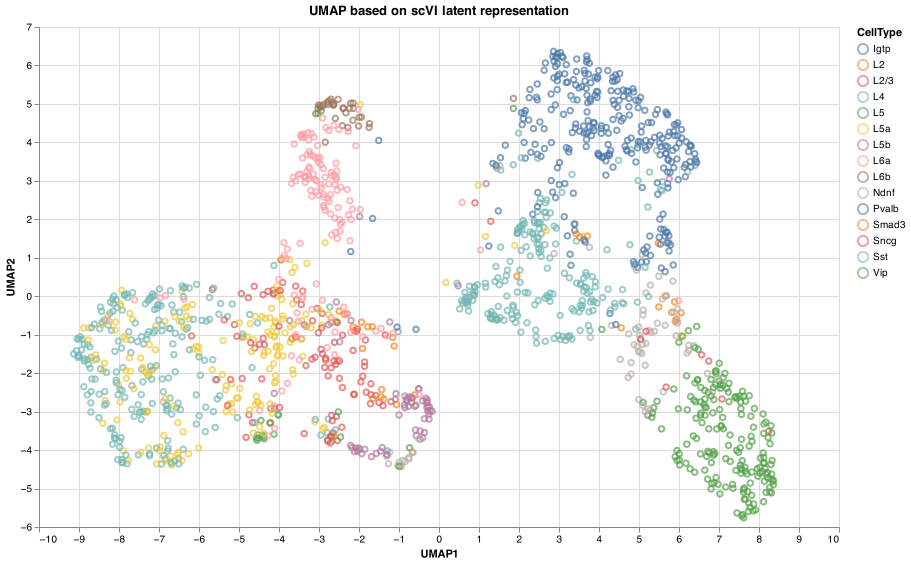

In [38]:
umap_plot |>
@vlplot(:point, 
    x=:UMAP1, y = :UMAP2, 
    color = :CellType, 
    width = 800, height=500,
    title="UMAP based on scVI latent representation"
)

Now, lets make it interpretable!

## Linearly Decoded Variational Autoencoder (LDVAE)

The LDVAE model is an inherently interpretable variational autoencoder that has a similar underlying architecture as `scVI`. 

Using a negative binomial distribution, every cell represented by latent variables in the lower-dimensional latent space of `scVI` would be decoded to get the parameters for each gene in that cell. But it's hard to figure out what the low-dimensional latent representations mean. So, it is not easily possible to identify which genes influenced the representation of a particular cell. Svensson et al. (2020) show that they can use the flexibility of the non-linear representation of data without losing interpretability. However, in this model, a trade-off is made between the fit of the model and its interpretability, reflected in an increase in reconstruction error. The generative model of LDVAE remains very close to that of the classical `scVI` framework. However, one of the decoder networks, which estimates the expected number of transcripts per gene, is replaced by a linear factor model. Due to the linearity of the decoder, interpretability can be secured. This linear factor model assigns a weight to each gene in each cell, making the influence of this gene on the representation of the cell intelligible (Svensson et al. 2020). Factor analysis, a generalization of the well-known principal components analysis, provides a generative model based on linear Gaussian latent variables (Murphy 2022). In factor analysis, the genes are modeled as linear combinations of the latent variables with an added error term. These linear combinations of several correlated genes are also referred to as meta-genes in the literature (Raychaudhuri et al. 1999; Brunet 2004; Svensson et al. 2020).

<img src="figures/ldvae_architecture.png" />

*Taken from: Svensson, V., et al. "Interpretable factor models of single-cell RNA-seq via variational autoencoders." Bioinformatics 36.11 (2020)*

### Initialize LDVAE model 

Just like with `scVI`, we first compute the library sizes.

In [39]:
# calculate library size 
library_log_means, library_log_vars = init_library_size(adata)

([11.124279022216797], [0.4693736433982849])

Next, we initialize the single-cell LDVAE `scLDVAE()` using the same hyperparameters as before.

In [40]:
Random.seed!(111)
m = scLDVAE(size(adata.countmatrix,2);
    n_layers=1,
    n_latent=4,
    dispersion=:gene,
    gene_likelihood=:nb,
    library_log_means=library_log_means,
    library_log_vars=library_log_vars
);

┌ Warning: Using an activation function for the decoder is not supported in a LDVAE model, choice will be overridden
└ @ scVI /Users/martintreppner/.julia/packages/scVI/KqfV9/src/scLDVAE.jl:235


### Set training hyperparameters

In [41]:
# train model
training_args = TrainingArgs(
    max_epochs=200,
    batchsize=64,
    lr=0.001,
    n_epochs_kl_warmup=50,
    weight_decay=Float32(1e-6),
    register_losses=true,
    progress=false
);

## Train model

In [42]:
Random.seed!(59)
train_model!(m, adata, training_args)

┌ Info: Starting training for 200 epochs...
└ @ scVI /Users/martintreppner/.julia/packages/scVI/KqfV9/src/Training.jl:73
┌ Info: training complete!
└ @ scVI /Users/martintreppner/.julia/packages/scVI/KqfV9/src/Training.jl:93


(scVAE(180, 1, 128, 4, 1, :gene, 0.1f0, true, :nb, :normal, true, Dict{Any, Any}("total_loss" => Any[1442.1573f0, 1394.6343f0, 1362.4222f0, 1333.1289f0, 1306.6239f0, 1281.7479f0, 1258.208f0, 1235.0051f0, 1213.4318f0, 1193.0658f0  …  487.68115f0, 486.98184f0, 486.8142f0, 486.12296f0, 485.50394f0, 484.77417f0, 484.49554f0, 483.99716f0, 483.7041f0, 482.578f0], "kl_z" => Any[11.264993f0, 10.682789f0, 11.103243f0, 11.308535f0, 11.531337f0, 11.832274f0, 12.099364f0, 12.34341f0, 12.44208f0, 12.594339f0  …  5.364243f0, 5.2345333f0, 5.1768594f0, 5.05015f0, 5.267664f0, 5.373823f0, 5.343474f0, 5.279741f0, 5.4330573f0, 5.7276535f0], "reconstruction" => Any[1441.9318f0, 1394.2069f0, 1361.7562f0, 1332.2242f0, 1305.4707f0, 1280.328f0, 1256.5139f0, 1233.0303f0, 1211.1921f0, 1190.5468f0  …  482.31693f0, 481.74728f0, 481.6374f0, 481.07288f0, 480.23618f0, 479.40033f0, 479.152f0, 478.71738f0, 478.27106f0, 476.85037f0], "kl_l" => Any[0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0, 0.0f0  …  

In [16]:
# Extract reconstruction loss from trained model
reconstruction_loss_ldvae = m.loss_registry["reconstruction"];
reconstruction_loss_ldvae = DataFrame(hcat(collect(1:size(reconstruction_loss_ldvae,1)), reconstruction_loss_ldvae, repeat(["LDVAE"], size(reconstruction_loss_scvi,1))), :auto);
rename!(reconstruction_loss_ldvae, :x1 => :epoch, :x2 => :reconstruction_loss, :x3 => :model);

# Combine with scVI reconstruction loss
reconstruction_loss_combined = vcat(reconstruction_loss_scvi, reconstruction_loss_ldvae);

Here we can see that the interpretable `LDVAE` has a higher reconstruction loss than `scVI`, which is the disadvantage we have to accept in exchange for interpretability.

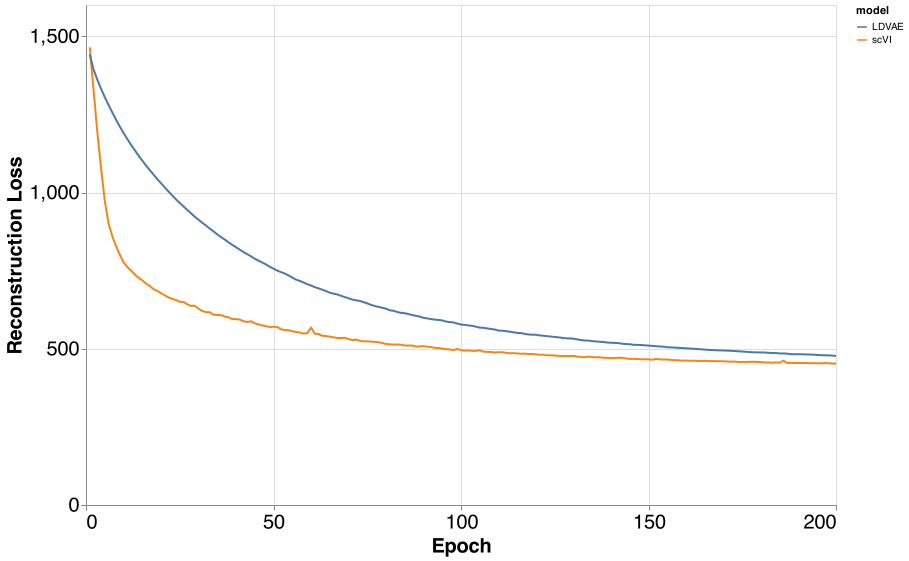

In [17]:
# Plot training progress
reconstruction_loss_combined |>
@vlplot(
    width=750,
    height=500,
    :line, 
    x={"epoch:q", title="Epoch", axis={titleFontSize=20, labelFontSize=20, tickCount=5}}, 
    y={"reconstruction_loss:q", title="Reconstruction Loss", axis={titleFontSize=20, labelFontSize=20, tickCount=5}},
    color=:model
)

In [18]:
# Extract latent representation
latent = get_latent_representation(m, adata.countmatrix)

4×1525 Matrix{Float32}:
 -0.373244  -0.154935    1.33942   …  -0.2424    -0.518072  0.338984
  2.38566    1.35496    -1.08337       1.58156    1.6401    1.81726
  0.568818   0.797437    0.179525      0.492824  -0.202217  0.410193
  0.127253  -0.0422956  -0.407033      0.190539   0.819697  0.28746

## Evaluate and visualize training

As before, we can run UMAP on the 10-dimensional latent representation from our model to visualie the cells in two dimensions.

In [19]:
# Compute UMAP
using UMAP
umap_latent = umap(latent, 2; min_dist = 0.3); # # umap input assumes shape n_featues x n_samples
umap_latent = Array{Float64,2}(umap_latent');
umap_plot = DataFrame(UMAP1=umap_latent[:,1],UMAP2=umap_latent[:,2]);
umap_plot[!,:CellType] = vec(adata.celltypes);

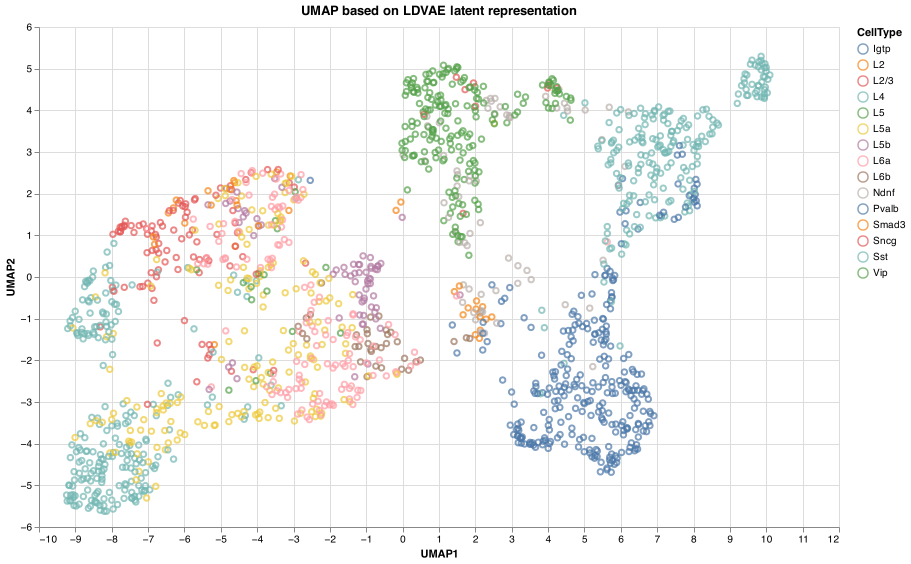

In [20]:
umap_plot |>
@vlplot(:point, 
    x=:UMAP1, y = :UMAP2, 
    color = :CellType, 
    width = 800, height=500,
    title="UMAP based on LDVAE latent representation"
)


# Interpretability

Svensson et al. (2020) state that the proportion of variance explained by each latent variable can be computed, which brings additional advantages for interpretability.

Hence, we first run PCA on the latent variables that we extracted from the LDVAE model.

In [43]:
# gene names
using Statistics
using LinearAlgebra
gene_names = adata.vars["gene_names"]

# cell names
cell_annotation = adata.obs["GABAvsGluta"]

loadings = get_loadings(m.decoder)

# Select variables to plot
plot_var1, plot_var2 = [1,2]

# Determine variance explained by each latent variable
Zcentered = latent .- mapslices(mean,latent,dims=2);
Zscaled = latent ./ mapslices(std,latent,dims=2);
ZTZ = cov(Zscaled',dims=2);
    
eigen_values = abs.(eigvals(ZTZ));
singular_values = sqrt.(eigen_values);

variance_explained = singular_values ./ sum(singular_values);

# Order latents variables and loadings by their explained variance
idx = sortperm(variance_explained, rev=true);
latent_ordered = latent;
loadings_ordered = loadings;

w_columns = [Symbol(string("x$plot_var1")), Symbol(string("x$plot_var2"))];

latent_plot = DataFrame(hcat(adata.celltypes,latent_ordered'),:auto);
rename!(latent_plot, :x1 => :celltype, :x2 => :x1, :x3 => :x2, :x4 => :x3, :x5 => :x4)
loadings_plot = DataFrame(hcat(gene_names,loadings_ordered),:auto);
rename!(loadings_plot, :x1 => :Gene, :x2 => :x1, :x3 => :x2, :x4 => :x3, :x5 => :x4)

tmp_w_ordered = DataFrame(deepcopy(loadings_plot));
tmp_w_ordered.lnth = mapslices(LinearAlgebra.norm, Array{Float64,2}(tmp_w_ordered[:,w_columns]), dims=2)[:,1];

number_of_genes = adata.ngenes;
ggg = sort(tmp_w_ordered, :lnth, rev=true);
ggg_plot = ggg[1:number_of_genes,[:Gene, w_columns[1], w_columns[2], :lnth]];
ggg_plot.origin1 .= 0.0;
ggg_plot.origin2 .= 0.0;

ggg_plot

180×6 DataFrame
 Row │ Gene    x1          x2           lnth       origin1  origin2 
     │ Any     Any         Any          Float64    Float64  Float64 
─────┼──────────────────────────────────────────────────────────────
   1 │ Cpne5   -1.1504     -2.01989     2.32452        0.0      0.0
   2 │ Htr2c   1.26702     1.7856       2.18945        0.0      0.0
   3 │ Ctxn3   1.18316     -1.74528     2.10852        0.0      0.0
   4 │ Grm2    1.63594     -1.18637     2.02083        0.0      0.0
   5 │ Ly6d    1.34631     1.25674      1.84172        0.0      0.0
   6 │ Htr4    0.399698    1.75635      1.80126        0.0      0.0
   7 │ Mybpc1  0.352317    1.74428      1.77951        0.0      0.0
   8 │ Htr3a   -0.0500342  1.76844      1.76914        0.0      0.0
   9 │ Adora1  0.75388     -1.5784      1.74919        0.0      0.0
  10 │ Cbln4   0.822529    -1.54081     1.74661        0.0      0.0
  11 │ Htr5b   1.22748     1.16238      1.69052        0.0      0.0
  ⋮  │   ⋮         ⋮            ⋮           ⋮         ⋮        ⋮
 171 │ Bcl6    0.147728    0.257763     0.297094       0.0      0.0
 172 │ Batf3   -0.180709   -0.218138    0.283266       0.0      0.0
 173 │ Grm1    -0.264196   -0.0894743   0.278935       0.0      0.0
 174 │ Ctgf    0.108353    0.256073     0.278053       0.0      0.0
 175 │ C1qb    0.122148    0.24515      0.273895       0.0      0.0
 176 │ Qrfpr   0.13948     0.227551     0.266897       0.0      0.0
 177 │ Gabra3  0.152448    -0.202649    0.253588       0.0      0.0
 178 │ Mog     0.125462    0.150061     0.195599       0.0      0.0
 179 │ Gria1   0.103086    -0.0759538   0.128046       0.0      0.0
 180 │ Crip1   -0.0649849  -0.00889562  0.0655909      0.0      0.0
                                                    159 rows omitted

In [22]:
# Extract genes with the highest loadings
relevant_genes = ggg_plot[!,:Gene][1:10]
ggg_plot = filter(row -> row.Gene == relevant_genes[1] || 
                                    row.Gene == relevant_genes[2] || 
                                    row.Gene == relevant_genes[3] || 
                                    row.Gene == relevant_genes[4] || 
                                    row.Gene == relevant_genes[5] || 
                                    row.Gene == relevant_genes[6] ||
                                    row.Gene == relevant_genes[7] ||
                                    row.Gene == relevant_genes[8] ||
                                    row.Gene == relevant_genes[9] ||
                                    row.Gene == relevant_genes[10],
                                    ggg_plot);

var_exp_1 = round(Array{Float64,1}(variance_explained[idx])[1] * 100, digits=2);
var_exp_2 = round(Array{Float64,1}(variance_explained[idx])[2] * 100, digits=2);


# Visualization

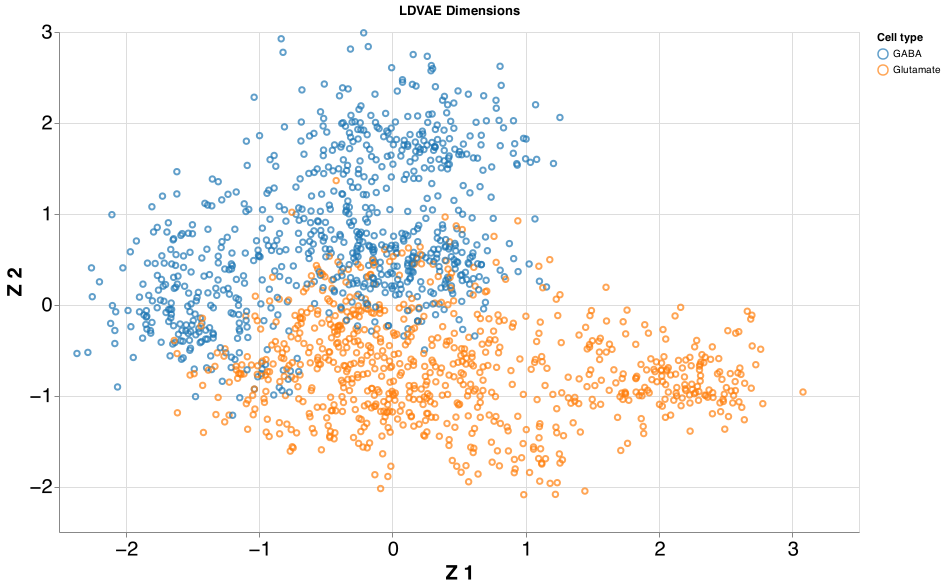

In [23]:
# Data prep latents
tmp = hcat(cell_annotation, latent');
latent_plot_latent = DataFrame(tmp,:auto);
columns= ["celltype","Z_1","Z_2","Z_3","Z_4"]
rename!(latent_plot_latent, names(latent_plot_latent) .=>  columns)

p1 = latent_plot_latent |>
@vlplot(:point, 
        title="LDVAE Dimensions", 
        x={"Z_$plot_var1:q", title = "Z $plot_var1", axis={titleFontSize=20, labelFontSize=20, tickCount=5}}, 
        y={"Z_$plot_var2:q", title = "Z $plot_var2", axis={titleFontSize=20, labelFontSize=20, tickCount=5}}, 
        color = {"celltype:n",scale={scheme=:category10}, legend={title="Cell type"}}, 
        width = 800, height=500
)

Now we can infer the corresponding information about co-expressed genes from the factor model’s loadings. More specifically, loadings for *Cpne5*, *Htr2c*, *Ctxn3*, *Grm2*, *Ly6d*, *Htr4*, *Mybpc1*, *Htr3a*, *Adora1*, and *Cbln4* indicate groups of genes that are specifically expressed in GABAergic and glutamatergic cells. The model can infer gene programs by examining more latent dimensions for extracting co-expressed genes.


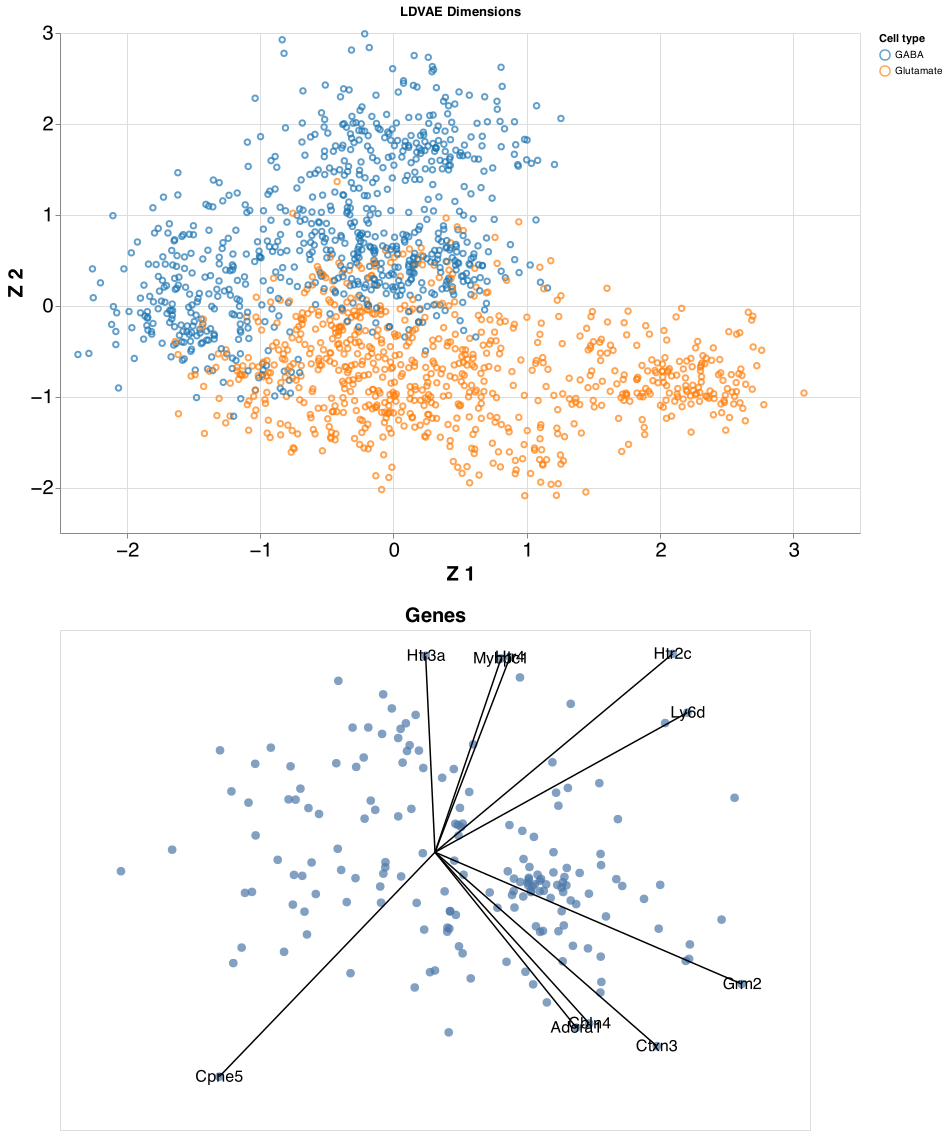

In [24]:
# Data prep loadings
tmp = hcat(gene_names, loadings_ordered);
loadings_plot_loadings = DataFrame(tmp,:auto);
columns= ["Gene","W_1","W_2","W_3","W_4"]
rename!(loadings_plot_loadings, names(loadings_plot_loadings) .=>  columns)

# Convert to proper types
loadings_plot_loadings[!,:W_1] = convert(Array{Float64,1}, loadings_plot_loadings[!,:W_1]);
loadings_plot_loadings[!,:W_2] = convert(Array{Float64,1}, loadings_plot_loadings[!,:W_2]);
loadings_plot_loadings[!,:W_3] = convert(Array{Float64,1}, loadings_plot_loadings[!,:W_3]);
loadings_plot_loadings[!,:W_4] = convert(Array{Float64,1}, loadings_plot_loadings[!,:W_4]);

tmp1 = Array{Any,2}(ggg_plot);
loadings_plot_genes = DataFrame(tmp1,:auto);
columns= ["Gene","W_$plot_var1", "W_$plot_var2", "lnth", "origin1", "origin2"]
rename!(loadings_plot_genes, names(loadings_plot_genes) .=>  columns)

# Convert to proper types
ggg_plot[!,:x1] = convert(Array{Float64,1}, ggg_plot[!,:x1]);
ggg_plot[!,:x2] = convert(Array{Float64,1}, ggg_plot[!,:x2]);
ggg_plot[!,:Gene] = convert(Array{String,1}, ggg_plot[!,:Gene]);

p2 = @vlplot(width=750,height=500,resolve={scale={x="shared",y="shared"}}) +
@vlplot(title ={text = "Genes", fontSize=20},
    :circle, 
    data = loadings_plot_loadings,
    x={"W_$plot_var1:q", title=string("W $plot_var1"), axis={titleFontSize=20, labelFontSize=20, tickCount=5}}, 
    y={"W_$plot_var2:q", title=string("W $plot_var2"), axis={titleFontSize=20, labelFontSize=20, tickCount=5}},
    size={value=75},
    config={legend={titleFontSize=10, labelFontSize=20}}
) +
@vlplot(
    mark={
        type=:rule
    },
    data=ggg_plot,
    x={"x$plot_var1:q", axis=nothing},
    y={"x$plot_var2:q", axis=nothing},
    x2={"origin1", axis=nothing},
    y2={"origin2", axis=nothing},
    size={value=1.5}
) +
@vlplot(
    mark={
        type=:text
    },
    data=ggg_plot,
    x={"x$plot_var1:q", axis=nothing},
    y={"x$plot_var2:q", axis=nothing},
    text={
        field=:Gene,
        type=:nominal
    },
    size={value=16}
);

@vlplot() +
[
    p1;
    p2
]

In [25]:
# List of 10 most relevant genes
relevant_genes

10-element Vector{Any}:
 "Cpne5"
 "Htr2c"
 "Ctxn3"
 "Grm2"
 "Ly6d"
 "Htr4"
 "Mybpc1"
 "Htr3a"
 "Adora1"
 "Cbln4"

Here you can see marker genes for **(a)** GABAergic neurons, **(b)** glutamatergic neurons, and **(c)** non-neuronal cells from the original study of Tasic et al. (2016).

<img src="figures/gaba_gluta.jpg" />

*Taken from: Tasic, B., et al. "Adult mouse cortical cell taxonomy revealed by single cell transcriptomics." Nature neuroscience 19.2 (2016)*

## Sources

*Tasic, B., et al. "Adult mouse cortical cell taxonomy revealed by single cell transcriptomics." Nature neuroscience 19.2 (2016): 335-346.*

*Lopez, R., et al. "Deep generative modeling for single-cell transcriptomics." Nature methods 15.12 (2018): 1053-1058.*

*Svensson, V., et al. "Interpretable factor models of single-cell RNA-seq via variational autoencoders." Bioinformatics 36.11 (2020): 3418-3421.*

*Treppner, M., et al. "Interpretable generative deep learning: an illustration with single cell gene expression data." Hum Gen (2022): 1-18.*

